In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.stats import kde
import datetime
import time
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Càrrega de les dades de Los Angeles

In [2]:
start = time.time() 
la_crime = pd.read_csv('https://data.lacity.org/api/views/63jg-8b9z/rows.csv')
print ("Descarregant dades...")
print ("Temps de descàrrega {} sec\n".format(time.time() - start))
print ("Carregades les dades de Los Angeles,", len(la_crime), "registres")

Descarregant dades...
Temps de descàrrega 99.850839138031 sec

Carregades les dades de Los Angeles, 2114550 registres


## Estudi de les dades i pre-processat

In [3]:
print (la_crime.head())
print (la_crime.describe())
for col in la_crime.columns: 
    print (col, len(la_crime[col].unique()), la_crime[col].dtype)

       DR_NO               Date Rptd                DATE OCC  TIME OCC  AREA   \
0    1307355  02/20/2010 12:00:00 AM  02/20/2010 12:00:00 AM      1350     13   
1   11401303  09/13/2010 12:00:00 AM  09/12/2010 12:00:00 AM        45     14   
2   70309629  08/09/2010 12:00:00 AM  08/09/2010 12:00:00 AM      1515     13   
3   90631215  01/05/2010 12:00:00 AM  01/05/2010 12:00:00 AM       150      6   
4  100100501  01/03/2010 12:00:00 AM  01/02/2010 12:00:00 AM      2100      1   

   AREA NAME  Rpt Dist No  Part 1-2  Crm Cd  \
0     Newton         1385         2     900   
1    Pacific         1485         2     740   
2     Newton         1324         2     946   
3  Hollywood          646         2     900   
4    Central          176         1     122   

                                         Crm Cd Desc    ...    Status  \
0                           VIOLATION OF COURT ORDER    ...        AA   
1  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...    ...        IC   
2          

## Descripció dels camps

https://data.lacity.org/A-Safe-City/Crime-Data-from-2010-to-2019/63jg-8b9z 

<ul>
    <li>'DR_NO': És l'identificador de cada cas, les dades són de tipus int64, per tant, serà útil per identificar cada registre </li>
    <li>'Date Rptd': Data en què s'ha recollit la denúncia. No es considera útil i s'elimina. </li>
    <li>'DATE OCC': La data en què han passat o s'estima que han passat els fets. Cal transformar-ho a format de data i també s'extrauran altres variables relacionades amb la data. </li>
    <li>'TIME OCC': L'hora en què han passat o s'estima que han passat els fets. Cal transformar-ho a format dd'hora i es crearà un camp unificat amb la data per tenir un moment concret. </li>
    <li>'AREA ': Codi numèric de l'àrea policial on han passat els fets. N'hi ha 21. </li>
    <li>'AREA NAME': Nom de l'àrea policial on han passat els fets. N'hi ha 21 i corresponen amb els codis d'AREA. </li>
    <li>'Rpt Dist No': Codi numèric de la subàrea geogràfica. N'hi ha 1303 registres únics.</li>
    <li>'Part 1-2': Camp numèric amb dos valors únics, 1 i 2, encara que no s'ha pogut determinar a què corresponen. </li>
    <li>'Crm Cd': Codi del delicte comès, 142 valors diferents. </li>
    <li>'Crm Cd Desc': Descripció del delicte comès, 142 valors diferents.</li>
    <li>'Mocodes': Codis del modus operandi. Cada camp pot contenir més d'un codi. Inicialment no es tractarà amb aquesta informació, que caldria separar per poder analitzar-la de manera adequada. </li>
    <li>'Vict Age': Camp numèric amb l'edat de la víctima. Es descarta el seu ús. </li>
    <li>'Vict Sex': Camp amb el codi del sexe de la víctima (Dona, Home o desconegut). Es descarta el seu ús. </li>
    <li>'Vict Descent': Camp amb una codificació de lletra per identificar l'origen de la víctima. Es descarta el seu ús. </li>
    <li>'Premis Cd': Codi sobre el tipus de lloc on han passat els fets. 
    <li>'Premis Desc': Informació sobre el tipus lloc on han passat els fets. </li>
    <li>'Weapon Used Cd': Codi sobre el tipus d'arma utilitzat en el delicte. </li>
    <li>'Weapon Desc': Descripcío del tipus d'arma utilitzada.  </li>
    <li>'Status': Codi sobre l'estat del cas, indica, per exemple, si s'ha detingut una persona o si contniua la investigació (situació per defecte).  Es descarta el seu ús</li>
    <li>'Status Desc': Descripció de l'estat del cas, indica, per exemple, si s'ha detingut una persona o si contniua la investigació (situació per defecte). Es descarta el seu ús  </li>
    <li>'Crm Cd 1': Codi del fet principal que ha tingut lloc. </li>
    <li>'Crm Cd 2': Codi d'un eventual fet secundari que ha tingut lloc en el mateix fet. Caldria afegir noves línies per aquests fets. </li>
    <li>'Crm Cd 3': Codi d'un eventual fet terciari que ha tingut lloc en el mateix fet. Caldria afegir noves línies per aquests fets.</li>
    <li>'Crm Cd 4': Codi d'un eventual quart fet que ha tingut lloc en el mateix fet. Caldria afegir noves línies per aquests fets.</li>
    <li>'LOCATION': Adreça del lloc on han passat els fets. Es descarta aquest camp. </li>
    <li>'Cross Street': Creuament dels carrers. Es descarta aquest camp. </li>
    <li>'LAT' : Latitud del lloc dels fets. Igual que les coordenades, la ubicació pot estàr parcialment moguda, però hauria de correspondre a la mateixa illa de cases.</li>
    <li>'LON' : Longitud del lloc dels fets. Igual que les coordenades, la ubicació pot estàr parcialment moguda, però hauria de correspondre a la mateixa illa de cases.</li> 

## Neteja de les dades i visualitzacions

In [4]:
la_crime = la_crime.drop(['Date Rptd', 'Vict Age', 'Vict Sex', 
                          'Vict Descent', 'Status', 'Status Desc', 
                          'LOCATION', 'Cross Street'], axis=1)

la_crime['TIME OCC']=la_crime['TIME OCC'].apply(lambda x:str(x).zfill(4)[:2]+':'+str(x).zfill(4)[2:])
la_crime['DATE OCC']= la_crime['DATE OCC'].apply(lambda x:x[:10])
la_crime['DATE OCC'] = pd.to_datetime(la_crime['DATE OCC'], format='%m/%d/%Y').dt.date
la_crime['TIME OCC'] = pd.to_datetime(la_crime['TIME OCC'], format='%H:%M').dt.time

print (len(la_crime))
la_crime = la_crime[(la_crime['LAT']>33.6) & (la_crime['LAT']<34.4) & (la_crime['LON']<-118)] 
print (len(la_crime))

2114550
2113547


In [5]:
selCols = ['Crm Cd 1', 'Crm Cd 2','Crm Cd 3','Crm Cd 4']
selList = []
i = 0
for col in selCols: 
    la_crime_c = la_crime[la_crime[col].notna()]
    i = i + len(la_crime_c)
    print (i)
    la_crime_c['Crm Cd n'] = la_crime[col]
    la_crime_c['Crm Cd Cd'] = col
    la_crime_c = la_crime_c.drop(selCols, axis=1)
    selList.append(la_crime_c)
la_crime_bis = pd.concat(selList)
print (len(la_crime_bis))
print (la_crime_bis.columns)

2113537


/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


2252711
2256203
2256307
2256307
Index(['DR_NO', 'DATE OCC', 'TIME OCC', 'AREA ', 'AREA NAME', 'Rpt Dist No',
       'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Premis Cd',
       'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'LAT', 'LON',
       'Crm Cd n', 'Crm Cd Cd'],
      dtype='object')


/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


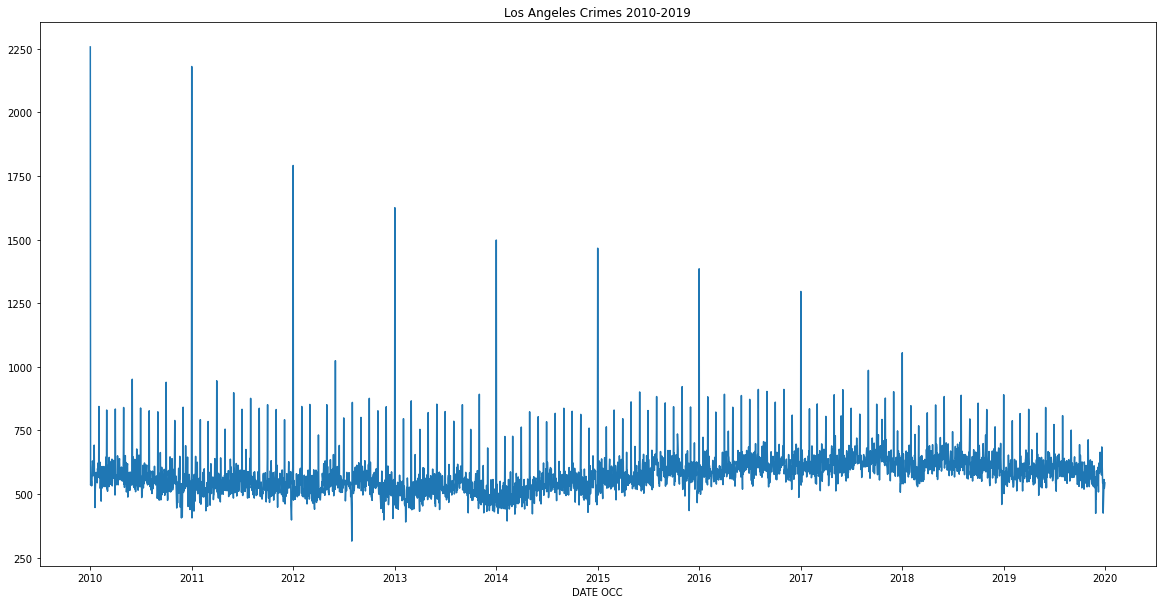

In [6]:
la_crime.groupby('DATE OCC').DR_NO.count().plot.line(figsize=(20,10), title="Los Angeles Crimes 2010-2019")

In [7]:
la_crime['Latitude2'] = la_crime['LAT'].round(2)
la_crime['Longitude2'] = la_crime['LON'].round(2)

print ("Valors únics de Latitud i Longitud arrodonint a 2 decimals:")
print (len(la_crime.Latitude2.unique()), len(la_crime.Longitude2.unique()))
print("Punts únics amb 2 decimals:\n", str(len(la_crime.groupby(['Latitude2', 'Longitude2'])['DR_NO'].count())))

Valors únics de Latitud i Longitud arrodonint a 2 decimals:
66 68
Punts únics amb 2 decimals:
 1483


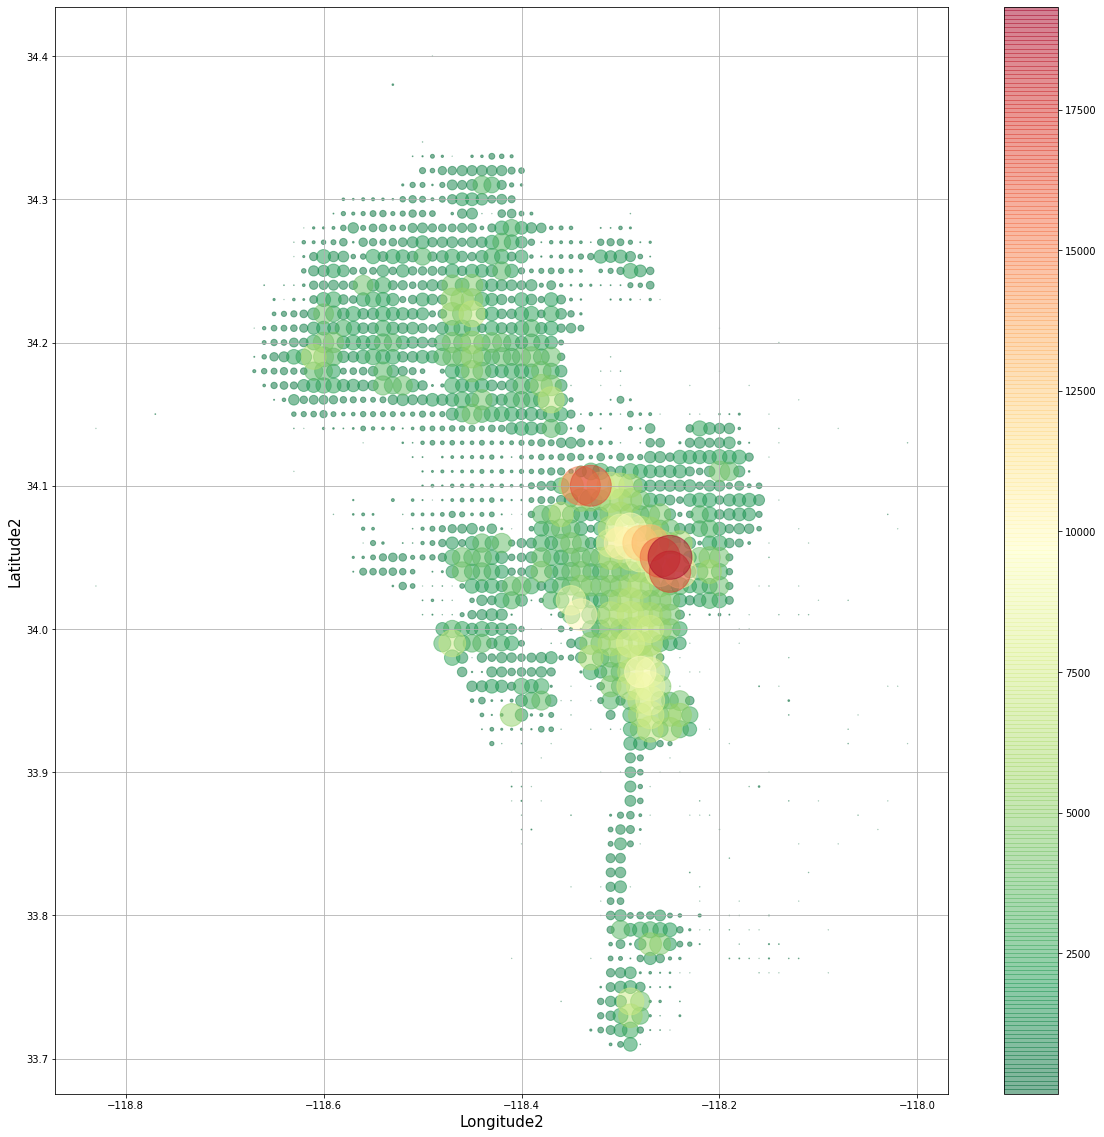

In [8]:
prov_map_lat = la_crime.groupby(['Latitude2','Longitude2']).DR_NO.count()
prov_map_lat = prov_map_lat.reset_index()
prov_map_lat = prov_map_lat.sort_values(by=['DR_NO'])


s = [n/10 for n in prov_map_lat.DR_NO]

fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(20)
cs = ax.scatter(prov_map_lat.Longitude2, prov_map_lat.Latitude2, s= s,  c = prov_map_lat.DR_NO, cmap='RdYlGn_r', alpha = 0.5)
ax.set_xlabel('Longitude2', fontsize = 15)
ax.set_ylabel('Latitude2', fontsize = 15) 
ax.grid(True)  
cbar = fig.colorbar(cs)
plt.show()

## Selecció de 2 anys    

In [9]:
dataInici = datetime.date(year=2018,month=1,day=1)
dataFi = datetime.date(year=2019,month=12,day=31)
print(len(la_crime))
la_crime = la_crime[(la_crime['DATE OCC']>=dataInici) & (la_crime['DATE OCC']<=dataFi)]
print(len(la_crime))

2113547
444571


# Primera etapa: Predicció diària per districtes 

In [10]:
la_district_crime = pd.pivot_table(la_crime, values='DR_NO', index='DATE OCC', columns=['AREA NAME'], aggfunc='count', fill_value=0)
print (la_district_crime.shape)

(730, 21)


In [11]:
# split into train and test sets
dataIniciTest = datetime.date(year=2019,month=12,day=1)
dataIniciVal = datetime.date(year=2019,month=10,day=1)

train = la_district_crime[la_district_crime.index<dataIniciVal]
validation = la_district_crime[(la_district_crime.index>=dataIniciVal) & (la_district_crime.index<dataIniciTest)]
test = la_district_crime[la_district_crime.index>=dataIniciTest]

# normalize the dataset
scaler = MinMaxScaler()
scaler.fit(train)
train_norm = scaler.transform(train)
validation_norm = scaler.transform(validation)
test_norm = scaler.transform(test)

In [12]:
n_input = 7
n_features = len(la_district_crime.columns)

trainGenerator = TimeseriesGenerator(train_norm, train_norm, length=n_input, batch_size=1)
validGenerator = TimeseriesGenerator(validation_norm, validation_norm, length=n_input)
testGenerator = TimeseriesGenerator(test_norm, test_norm, length=n_input)

In [13]:
import time
n_epochs = 20

start = time.time() 
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(200))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()
mfit = model.fit_generator(trainGenerator, validation_data=validGenerator, epochs=n_epochs)
L_results= ['Los Angeles', mfit]
print ('Temps execució acumulada {} sec\n'.format(time.time() - start))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 200)            177600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 21)                4221      
Total params: 502,621
Trainable params: 502,621
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
631/631 [==============================] - 17s 27ms/step - loss: 0.0225 - acc: 0.1442 - val_loss: 0.0201 - val_acc: 0.0556
Epoch 2/20
631/631 [==============================] - 15s 24ms/step - loss: 0.0202 - acc: 0.1506 - val_loss: 0.0204 - val_acc: 0.1852
Epoch 3/20
631/631 [==============================] - 17s 28ms/step - loss: 0.0199 - acc: 0.1458 - val_loss: 0.0186 - val_acc: 0.185

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


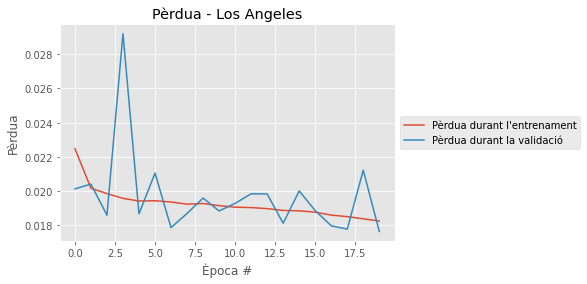

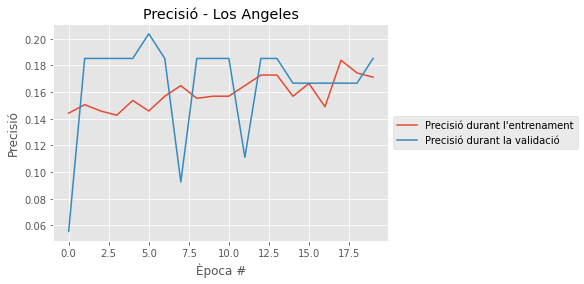

In [18]:
L_results= ['Los Angeles', mfit]

plt.style.use("ggplot")
plt.figure()

print (L_results[1].history.keys())
plt.plot(np.arange(0, n_epochs), L_results[1].history[list(L_results[1].history.keys())[2]], label="Pèrdua durant l'entrenament")
plt.plot(np.arange(0, n_epochs), L_results[1].history[list(L_results[1].history.keys())[0]], label="Pèrdua durant la validació")
plt.title("Pèrdua - "+L_results[0])
plt.xlabel("Època #")
plt.ylabel("Pèrdua")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()
    
plt.figure()

plt.plot(np.arange(0, n_epochs), L_results[1].history[list(L_results[1].history.keys())[3]], label="Precisió durant l'entrenament")
plt.plot(np.arange(0, n_epochs), L_results[1].history[list(L_results[1].history.keys())[1]], label="Precisió durant la validació")
plt.title("Precisió - "+L_results[0])
plt.xlabel("Època #")
plt.ylabel("Precisió")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [15]:
predList = []
batch = train_norm[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):   
    predList.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[predList[i]]],axis=1)

In [16]:
predCols = []
for col in la_district_crime.columns:
    predCols.append('Prediction_'+str(col))
df_predict = pd.DataFrame(scaler.inverse_transform(predList),
                          index=la_district_crime[-n_input:].index, columns=predCols)

df_test = pd.concat([la_district_crime,df_predict], axis=1)

/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
/Users/hitnas/anaconda/envs/py3k/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: Ma

rmse:  [5.04267503]


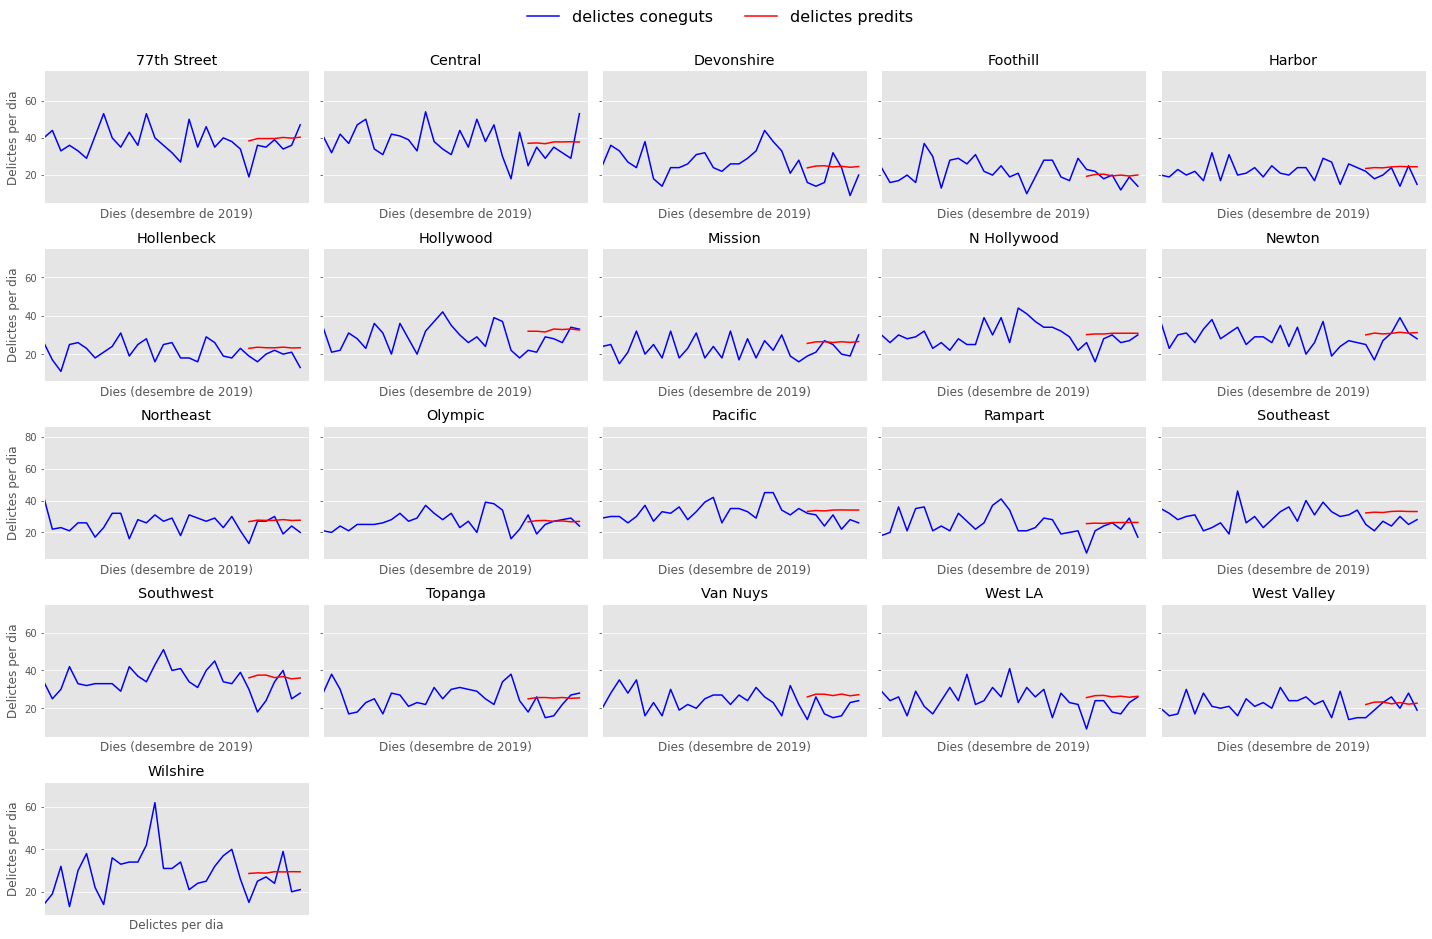

In [22]:
cols = 5 
rows = (len(la_district_crime.columns)+cols-1)//cols

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(20, (2.5*rows)),
                        sharex = 'col', sharey='row',
                        subplot_kw={'xticks': []})

axs = axs.flat
for ax in axs[len(la_district_crime.columns):]: 
    ax.remove()
axs = axs[:len(la_district_crime.columns)]
i = 0
for col in la_district_crime.columns:
    axs[i].plot(df_test.index, df_test[col], color ='b', label = 'delictes coneguts')
    axs[i].plot(df_test.index, df_test['Prediction_'+str(col)], color='r', label = "delictes predits")
    axs[i].set_xlim("2019-12-01", "2020-01-01")
    axs[i].set_title(str(col))
    if (i%cols) == 0: 
        axs[i].set_ylabel("Delictes per dia")    
    axs[i].set_xlabel("Dies (desembre de 2019)")    
    i = i+1 

lines, labels = fig.axes[-1]. get_legend_handles_labels()   
plt.figlegend(lines, labels, loc = 'lower center', ncol = 2, fontsize = 16,
              frameon = False, bbox_to_anchor=(0.5, 1) )
plt.tight_layout()

pred_actual_rmse = rmse(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
print("rmse: ", pred_actual_rmse)

In [20]:
la_district_crime.mean()

AREA NAME
77th Street    39.738356
Central        36.561644
Devonshire     25.201370
Foothill       21.339726
Harbor         24.260274
Hollenbeck     23.400000
Hollywood      30.760274
Mission        26.243836
N Hollywood    31.502740
Newton         29.519178
Northeast      27.153425
Olympic        28.916438
Pacific        33.332877
Rampart        26.142466
Southeast      32.326027
Southwest      38.002740
Topanga        27.530137
Van Nuys       27.234247
West LA        26.293151
West Valley    24.695890
Wilshire       28.846575
dtype: float64